✅ 데이터 복원 완료
 - Shape: (31, 31)
 - Min: 0.0000, Max: 0.9294


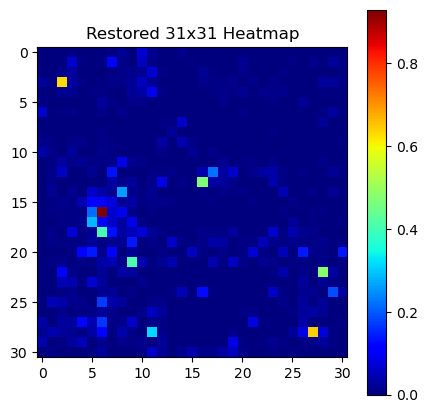

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def recover_heatmap_data(image_path, target_size=(31, 31)):
    # 1. 이미지 로드 (BGR 형태)
    img_bgr = cv2.imread(image_path)
    
    if img_bgr is None:
        print(f"❌ 파일을 찾을 수 없습니다: {image_path}")
        return None

    # 2. 빨간색 네모 부분 찾기 (마스크 생성)
    # BGR 기준 빨간색 범위: Blue/Green은 낮고, Red는 높은 영역
    lower_red = np.array([0, 0, 150])   # 진한 빨강 ~ 
    upper_red = np.array([100, 100, 255]) # 밝은 빨강
    
    red_mask = cv2.inRange(img_bgr, lower_red, upper_red)
    
    # 마스크를 살짝 넓혀서 네모의 경계선까지 확실하게 포함
    kernel = np.ones((3,3), np.uint8)
    red_mask = cv2.dilate(red_mask, kernel, iterations=1)

    # 3. 인페인팅 (Inpainting): 빨간 부분을 주변 색으로 덮어쓰기
    # 주변 픽셀값을 참조하여 자연스럽게 메꿉니다.
    img_clean = cv2.inpaint(img_bgr, red_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    # 4. 31x31 크기로 리사이즈 (Downsampling)
    # 이미지가 클 경우, 정보를 압축하는 INTER_AREA 방식이 가장 좋습니다.
    img_resized = cv2.resize(img_clean, target_size, interpolation=cv2.INTER_AREA)

    # 5. 점수(Score)로 변환
    # BGR -> Grayscale 변환
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    
    # 'gray_r' (0=흰색, 1=검정색)을 사용했다고 가정하고 역산
    # 검정색(0)에 가까울수록 높은 점수(1.0)
    # 흰색(255)에 가까울수록 낮은 점수(0.0)
    heatmap_scores = 1.0 - (img_gray.astype(float) / 255.0)

    return heatmap_scores

# --- 실행 ---
file_path = "/home/bongo/porter_notebook/research/qwen3/APM_dot_verifying/QWEN3_32B_top_attention_heads/kick/punching_bag/punching_bag_001639.jpg_300_700_rank01_L14_H33_score_0.5351.png"

restored_data = recover_heatmap_data(file_path, target_size=(31, 31))

if restored_data is not None:
    print(f"✅ 데이터 복원 완료")
    print(f" - Shape: {restored_data.shape}")
    print(f" - Min: {restored_data.min():.4f}, Max: {restored_data.max():.4f}")
    
    # 시각화 확인
    plt.figure(figsize=(5, 5))
    plt.imshow(restored_data, cmap='jet')
    plt.title("Restored 31x31 Heatmap")
    plt.colorbar()
    plt.show()